In [3]:
import pandas as pd
from matplotlib import pyplot
import numpy as np

from fbprophet import Prophet
from fbprophet.plot import plot_yearly
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

In [4]:
# get data into dataframes from local csv
trainAll = pd.read_csv('train.csv')

In [5]:
# get train test split dfs
def testTrainByStoreAndItem(storeNum, itemNum, proportion = 0.67):
    myStore = trainAll.loc[(trainAll['store'] == storeNum) & (trainAll['item'] == itemNum)]
    myStore.date = pd.to_datetime(myStore.date)
    myStore = myStore.reset_index()
    myStore = myStore.drop(columns=['store', 'item', 'index'])
    split = int(proportion*len(myStore))
    myStoreTrain = myStore[:split]
    myStoreTest = myStore[split:]
    myStoreTrain.columns = ['ds', 'y']

    return myStoreTrain, myStoreTest

In [6]:
train, test = testTrainByStoreAndItem(7,20)

In [7]:
# get error metrics, plot predictions vs actual sales, and return predictions
def showPredictions(storeNum, itemNum):
    train, test = testTrainByStoreAndItem(storeNum, itemNum)
    prophet = Prophet()
    prophet.add_seasonality(name='yearly', period=365, fourier_order=10)
    prophet.fit(train)

    future = prophet.make_future_dataframe(periods=len(test))
    forecast = prophet.predict(future)
    
    print("MSE is " + str(np.sqrt(mean_squared_error(test['sales'], forecast.yhat[-len(test):]))))
    fig = pyplot.figure(figsize=(20,6))
    pyplot.plot(test.date[:365], test.sales[:365])
    pyplot.plot(test.date[:365], forecast.yhat[-len(test):-len(test)+365], color='red')
    pyplot.show()
    return forecast.yhat[-len(test):]

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE is 6.725163247174081


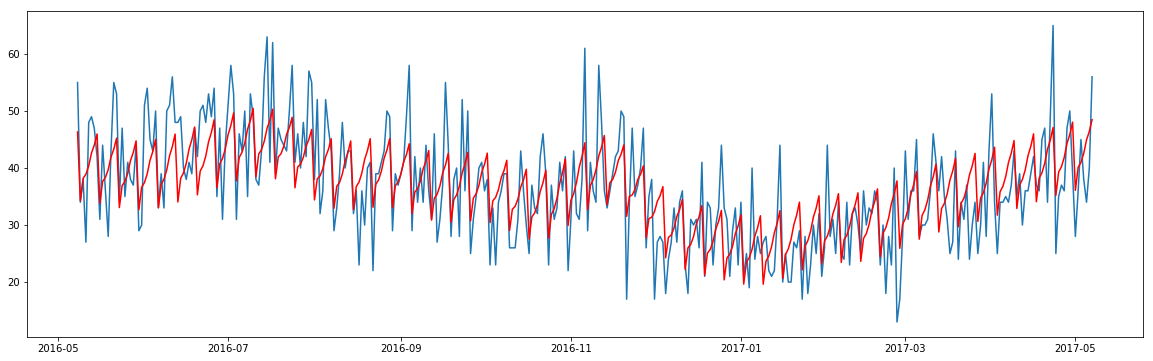

In [8]:
forecast = showPredictions(7, 20)

In [17]:
# set test df to datetime
test.date = pd.to_datetime(test.date)
test = test.set_index('date').groupby(['date']).sum()

In [25]:
# get predictions on monthly basis to see patterns
salesByMonth = test['sales'].resample('M', how='sum')
test['predictions'] = list(forecast)
predByMonth = test['predictions'].resample('M', how='sum')

6.725163247174081


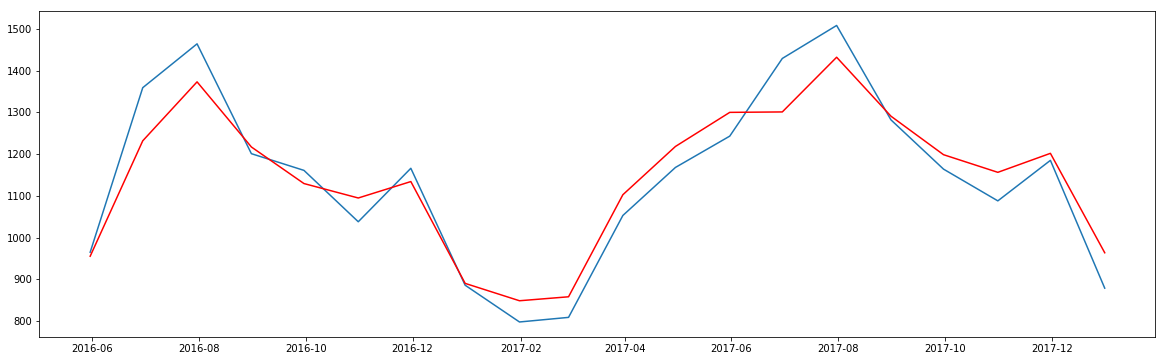

In [29]:
# plot monthly predictions vs actual monthly sales
print(np.sqrt(mean_squared_error(test['sales'], forecast)))
fig = pyplot.figure(figsize=(20,6))
pyplot.plot(salesByMonth.index, salesByMonth)
pyplot.plot(predByMonth.index, predByMonth, color='red')
pyplot.show()